In [43]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Data Preprocessing and Loading

In [16]:
df = pd.read_csv('../data/data.csv')
cpi = pd.read_csv('../data/cpi.csv')

In [17]:
df.head()

,FCID,BookingID,BCreatedDateAEST,BStatusHistoryID,BStatusAfterSubmitted,BStatusFromDateTimeAEST,BStatusSetByBizRules,BTicketID,BTicketType,TaskName,...,PriceIncGSTRaw,VYMM,VMakeModel,VMake,VYear,BShopID,BShopPostcode,BShopState,BShopRegionName,BShopRegionClass
0,7,2302949,29/04/2025,7088635,33. Approved,29/04/2025 8:37,NaN,3893269,Repair,Roadworthy Inspection / Pink Slips,...,49.00,2018 HYUNDAI I30 HATCHBACK/FASTBACK,HYUNDAI I30 HATCHBACK/FASTBACK,HYUNDAI,2018,17335,2120,NSW,Sydney,1
1,7,2275780,9/04/2025,6991456,33. Approved,9/04/2025 12:21,NaN,3840811,Repair,Check Fault Codes Inspection,...,633.60,2017 LINDE FORKLIFT,LINDE FORKLIFT,LINDE,2017,23083,3179,VIC,Melbourne,1
2,2,2230222,18/03/2025,6839386,33. Approved,18/03/2025 13:29,NaN,3754734,Log,"Logbook Service - 70,000 km / 42 months",...,492.19,2022 TOYOTA HILUX,TOYOTA HILUX,TOYOTA,2022,20207,2372,NSW,New England,2
3,1,406362,9/02/2021,2370566,23. Req. HA,11/02/2021 9:45,NaN,622983,Capped,"Capped Price Service - 30,000 km",...,443.81,2019 MITSUBISHI ECLIPSE CROSS,MITSUBISHI ECLIPSE CROSS,MITSUBISHI,2019,16999,2259,NSW,Central Coast,3
4,1,405426,7/02/2021,2365498,33. Approved,7/02/2021 18:48,NaN,621502,Repair,Battery Replacement,...,418.00,2018 HINO TRUCK,HINO TRUCK,HINO,2018,14366,2213,NSW,Sydney,1


In [ ]:
print(df.shape[0])
df = df.drop_duplicates(subset=[col for col in df.columns if col not in ['BookingID', 'BCreatedDateAEST', 'BStatusFinal', 'BTicketID' ]])
print(df.shape[0])

In [19]:
# Price adjustment for inflation
df['BCreatedDateAEST'] = pd.to_datetime(df['BCreatedDateAEST'], dayfirst=True);
df['Quarter'] = df['BCreatedDateAEST'].dt.to_period('Q');
cpi['Quarter'] = pd.to_datetime(cpi['Quarter']).dt.to_period('Q');
base_cpi = cpi['CPI'].iloc[-1]

C:\Users\jackl\AppData\Local\Temp\ipykernel_35640\3542310774.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cpi['Quarter'] = pd.to_datetime(cpi['Quarter']).dt.to_period('Q');


In [20]:
merged_df = df.merge(cpi, on='Quarter');
merged_df['Quarter'] = df['BCreatedDateAEST'].dt.quarter;

#Round to two decimal places to remain consistent with the existing data
merged_df['adjusted_price'] = round(merged_df['PriceIncGSTRaw'] * (base_cpi / merged_df['CPI']), 2)

In [21]:
pd.set_option('display.max_columns', None)
merged_df.head()

,FCID,BookingID,BCreatedDateAEST,BStatusHistoryID,BStatusAfterSubmitted,BStatusFromDateTimeAEST,BStatusSetByBizRules,BTicketID,BTicketType,TaskName,IsCustomService,IsCustomRepair,PriceIncGSTRaw,VYMM,VMakeModel,VMake,VYear,BShopID,BShopPostcode,BShopState,BShopRegionName,BShopRegionClass,Quarter,CPI,adjusted_price
0,1,402660,2021-02-01,2357659,33. Approved,1/02/2021 7:46,NaN,617590,Log,"Logbook Service - 240,000 km / 144 months",0,0,327.60,2019 TOYOTA HIACE,TOYOTA HIACE,TOYOTA,2019,14232,2289,NSW,Newcastle,2,2.0,117.9,387.34
1,1,402726,2021-02-01,2357875,23. Req. HA,1/02/2021 10:11,NaN,617693,Log,"Logbook Service - 70,000 km / 42 months",0,0,198.88,2017 TOYOTA RAV4,TOYOTA RAV4,TOYOTA,2017,16975,4551,QLD,Sunshine Coast,1,2.0,117.9,235.15
2,1,402727,2021-02-01,2357877,33. Approved,1/02/2021 10:11,NaN,617694,Log,"Logbook Service - 110,000 km / 66 months",0,0,330.00,2018 TOYOTA HILUX,TOYOTA HILUX,TOYOTA,2018,3589,4064,QLD,Brisbane,1,1.0,117.9,390.18
3,1,402768,2021-02-01,2357992,33. Approved,1/02/2021 11:25,NaN,617759,Capped,"Capped Price Service - 30,000 km",0,0,274.00,2018 HYUNDAI KONA,HYUNDAI KONA,HYUNDAI,2018,17069,6056,WA,Perth,2,1.0,117.9,323.97
4,1,402778,2021-02-01,2358026,33. Approved,1/02/2021 11:48,NaN,617776,Log,"Logbook Service - 100,000 km / 60 months",0,0,498.85,2019 TOYOTA YARIS,TOYOTA YARIS,TOYOTA,2019,14225,3066,VIC,Melbourne,1,1.0,117.9,589.82


In [22]:
columns_to_keep = ['BStatusAfterSubmitted', 'VMake', 'VMakeModel', 'VYear', 'adjusted_price', 'TaskName', 'BShopRegionClass']
df_filtered = merged_df[columns_to_keep]
df_filtered = df_filtered[df_filtered['BStatusAfterSubmitted'].isin(['33. Approved', '16. Req. Changes'])]
df_filtered['Label'] = df_filtered['BStatusAfterSubmitted'].map({'33. Approved': 1, '16. Req. Changes': 0})
df_filtered = df_filtered.drop('BStatusAfterSubmitted', axis=1)
df_filtered.head()

,VMake,VMakeModel,VYear,adjusted_price,TaskName,BShopRegionClass,Label
0,TOYOTA,TOYOTA HIACE,2019,387.34,"Logbook Service - 240,000 km / 144 months",2,1
2,TOYOTA,TOYOTA HILUX,2018,390.18,"Logbook Service - 110,000 km / 66 months",1,1
3,HYUNDAI,HYUNDAI KONA,2018,323.97,"Capped Price Service - 30,000 km",2,1
4,TOYOTA,TOYOTA YARIS,2019,589.82,"Logbook Service - 100,000 km / 60 months",1,1
5,TOYOTA,TOYOTA YARIS,2019,39.02,Custom Repair,1,1


In [23]:
X = df_filtered.drop(columns=['Label'])
y = df_filtered['Label']


In [24]:
# Absolute counts
print(y.value_counts())

# Relative proportions (percentages)
print(y.value_counts(normalize=True))

Label
0    73943
1    47994
Name: count, dtype: int64
Label
0    0.606403
1    0.393597
Name: proportion, dtype: float64


In [25]:
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].astype('category')

for col in X_test.select_dtypes(include='object').columns:
    X_test[col] = X_test[col].astype('category')

# Random Forest Model

In [ ]:
# Define categorical columns
categorical_cols = X.select_dtypes(include='category').columns.tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
    ],
    remainder='passthrough'  # keep numeric columns as-is
)
# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define hyperparameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': [None, 'balanced']
}

# GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='f1', verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate on the test set
y_pred = grid_search.predict(X_test)

print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

In [34]:
# Smaller grid for faster tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10],
    'classifier__class_weight': [None, 'balanced']
}

# GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, scoring='f1', verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Show best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate on the test set
y_pred = grid_search.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__n_estimators': 200}

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.60      0.66     14819
           1       0.51      0.65      0.57      9569

    accuracy                           0.62     24388
   macro avg       0.62      0.62      0.61     24388
weighted avg       0.64      0.62      0.62     24388



In [35]:
# Confidence score at the moment is its confidence in their prediction being correct
# Currently at 1 because its overfitting and is hence over confident 
def eval_classification_performance(model, train_X, y_train, eval_X, y_eval):
    """
    Evaluates a scikit-learn classification model on training and an evaluation dataset,
    displays confusion matrices, prints a classification report, and shows average confidence.

    Args:
        model: Trained scikit-learn classification model.
        train_X: Training features (pandas DataFrame).
        y_train: Training target (pandas Series).
        eval_X: Evaluation features (pandas DataFrame - typically validation or test).
        y_eval: Evaluation target (pandas Series - typically validation or test).
    """
    print("Evaluating model performance...")

    train_pred_labels = model.predict(train_X)

    eval_pred_labels = model.predict(eval_X)

    eval_pred_proba = model.predict_proba(eval_X)

    eval_confidence_in_prediction = np.max(eval_pred_proba, axis=1)

    train_acc = accuracy_score(y_train, train_pred_labels)
    eval_acc = accuracy_score(y_eval, eval_pred_labels) 

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Evaluation Accuracy: {eval_acc:.4f}") 

    print(f"Average Confidence in Predicted Class on Evaluation Set: {np.mean(eval_confidence_in_prediction):.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(15, 6)) 

    ConfusionMatrixDisplay.from_predictions(y_train, train_pred_labels, normalize='true', ax=axes[0])
    axes[0].set_title(f"Training Set Performance: Accuracy={train_acc:.2f}")
    axes[0].set_xlabel("Predicted label")
    axes[0].set_ylabel("True label")

    ConfusionMatrixDisplay.from_predictions(y_eval, eval_pred_labels, normalize='true', ax=axes[1])
    axes[1].set_title(f"Evaluation Set Performance: Accuracy={eval_acc:.2f}") 
    axes[1].set_xlabel("Predicted label")
    axes[1].set_ylabel("True label")


    plt.tight_layout()
    plt.show()

    print("\nEvaluation Set Classification Report:") 
    
    print(classification_report(y_eval, eval_pred_labels))


Evaluating model performance...
Training Accuracy: 0.6483
Evaluation Accuracy: 0.6195
Average Confidence in Predicted Class on Evaluation Set: 0.5964


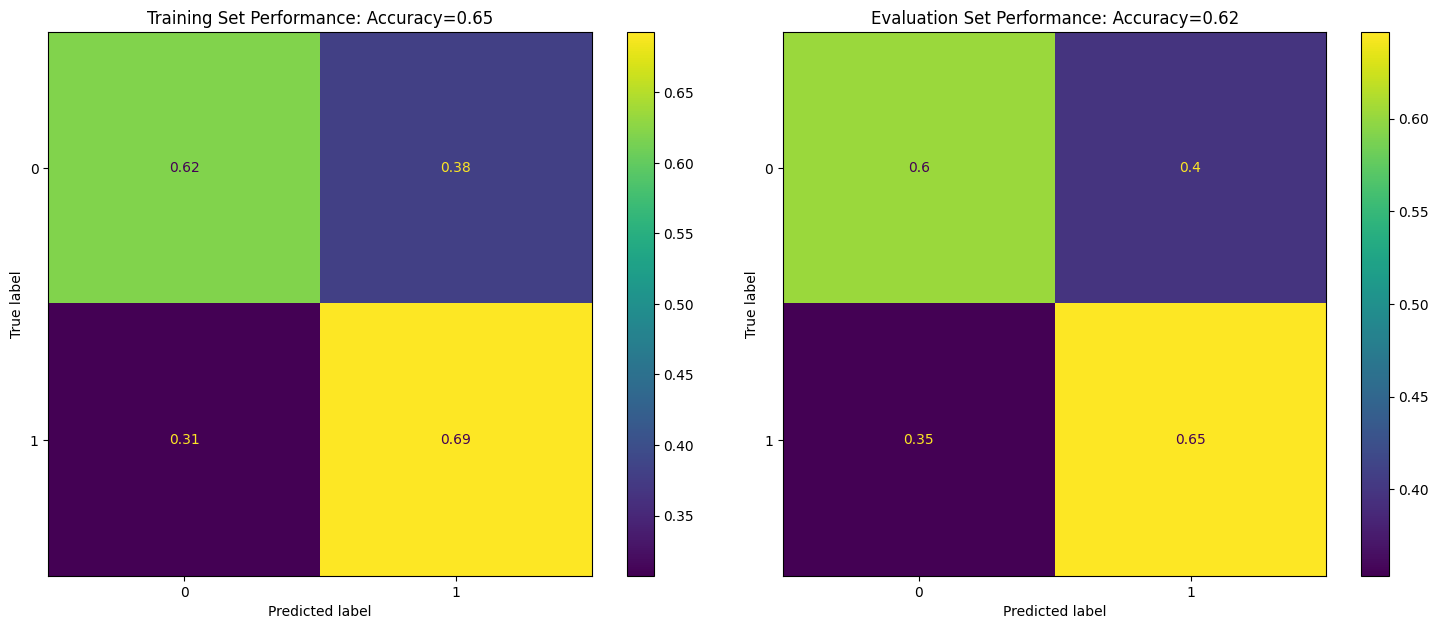


Evaluation Set Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.60      0.66     14819
           1       0.51      0.65      0.57      9569

    accuracy                           0.62     24388
   macro avg       0.62      0.62      0.61     24388
weighted avg       0.64      0.62      0.62     24388



In [38]:
eval_classification_performance(grid_search, X_train, y_train, X_test, y_test)

In [48]:
confidence_scores = grid_search.predict_proba(X_test)
predicted_labels = grid_search.predict(X_test)
confidence_class_1 = grid_search.predict_proba(X_test)[:, 1]

for label, conf in zip(predicted_labels, confidence_class_1):
    print(f"Predicted: {label}, Confidence: {conf:.4f}")

Predicted: 1, Confidence: 0.8012
Predicted: 0, Confidence: 0.4928
Predicted: 0, Confidence: 0.4743
Predicted: 0, Confidence: 0.4867
Predicted: 1, Confidence: 0.5848
Predicted: 0, Confidence: 0.4766
Predicted: 0, Confidence: 0.4797
Predicted: 1, Confidence: 0.5227
Predicted: 0, Confidence: 0.4159
Predicted: 0, Confidence: 0.3287
Predicted: 0, Confidence: 0.2782
Predicted: 1, Confidence: 0.6238
Predicted: 1, Confidence: 0.5325
Predicted: 1, Confidence: 0.5488
Predicted: 0, Confidence: 0.3967
Predicted: 0, Confidence: 0.4089
Predicted: 1, Confidence: 0.5849
Predicted: 1, Confidence: 0.6180
Predicted: 0, Confidence: 0.4986
Predicted: 1, Confidence: 0.5299
Predicted: 1, Confidence: 0.7677
Predicted: 0, Confidence: 0.4868
Predicted: 1, Confidence: 0.5557
Predicted: 1, Confidence: 0.6053
Predicted: 1, Confidence: 0.6252
Predicted: 1, Confidence: 0.6541
Predicted: 1, Confidence: 0.5391
Predicted: 1, Confidence: 0.8314
Predicted: 0, Confidence: 0.3367
Predicted: 1, Confidence: 0.5201
Predicted: